# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [42]:
df=pd.read_csv("Gold Price (2013-2023).csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.drop(columns=["Vol.","Change %","Open","High","Low"])
df.sort_values(by="Date",inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2583 entries, 2582 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2583 non-null   datetime64[ns]
 1   Price   2583 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 60.5+ KB


In [45]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

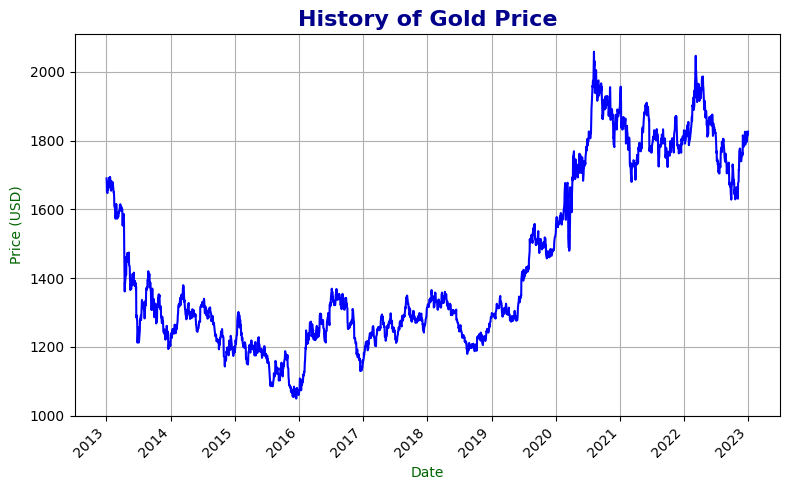

In [46]:
plt.figure(figsize=(8,5 )) 
plt.plot(df['Date'], df['Price'], color='blue',  markersize=6) 
plt.title('History of Gold Price', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Date', fontsize=10, color='darkgreen') 
plt.ylabel('Price (USD)', fontsize=10, color='darkgreen') 
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.tight_layout()
plt.show()

## Normalize data

In [47]:
prices = df['Price'].values  
prices_reshaped = prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(prices_reshaped)
print(normalized_data.shape)

(2583, 1)


In [48]:
ratio=0.80
train_size=int(len(df)*ratio)
test_size=len(df)-train_size
train_data,test_data=normalized_data[:train_size],normalized_data[train_size:]
print(f"all data: {len(df)}\ntrain data: {train_size}\ntest data: {test_size}")

all data: 2583
train data: 2066
test data: 517


## Creat the dataset

In [49]:
def create_dataset(dataset, time_step_in=1,time_step_out=1):
    X, Y = [], []

    for i in range(len(dataset) - time_step_in - time_step_out):
        a = dataset[i:(i + time_step_in), 0]
        X.append(a)
        
        b = dataset[(i + time_step_in):(i + time_step_in + time_step_out), 0]  
        Y.append(b)
    
    return np.array(X), np.array(Y)

time_step_in=30
time_step_out=30
X_train,y_train=create_dataset(train_data,time_step_out,time_step_in)
X_test,y_test=create_dataset(test_data,time_step_out,time_step_in)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (2006, 30) 
y_train: (2006, 30)
X_test: (457, 30)
y_test: (457, 30)


## Reshape

In [50]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(f"X_test shape => {X_test.shape}\nX_train shape => {X_train.shape}")

X_test shape => (457, 30, 1)
X_train shape => (2006, 30, 1)


## Model definition

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(30))
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

c:\Python_Projects\MachineLearning.khorsand\Alzimer\face\f\gold_price\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,530 (283.32 KB)

 Trainable params: 72,530 (283.32 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history=model.fit(
    X_train,y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    verbose=1
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.2590 - mean_absolute_error: 0.2590 - val_loss: 0.3660 - val_mean_absolute_error: 0.3660
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0968 - mean_absolute_error: 0.0968 - val_loss: 0.1471 - val_mean_absolute_error: 0.1471
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0594 - mean_absolute_error: 0.0594 - val_loss: 0.0771 - val_mean_absolute_error: 0.0771
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0528 - mean_absolute_error: 0.0528 - val_loss: 0.0604 - val_mean_absolute_error: 0.0604
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0505 - mean_absolute_error: 0.0505 - val_loss: 0.0577 - val_mean_absolute_error: 0.0577
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0751 - val_mean_absolute_error: 0.0751
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - v

## Model Evaluation

In [51]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0530 - mean_absolute_error: 0.0530
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [52]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [53]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: [0.05435092747211456, 0.05435092747211456]
Test MAPE: 0.07550013803370817
Test Accuracy: 0.9244998619662919


In [54]:
train_predicted = model.predict(X_train)
test_predicted = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [55]:
y_next_30 = model.predict(X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2]))
y_next_30=scaler.inverse_transform(y_next_30) 
y_next_30=np.round(y_next_30)
print(y_next_30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[1769. 1775. 1750. 1768. 1775. 1752. 1754. 1772. 1754. 1752. 1755. 1771.
  1763. 1778. 1771. 1757. 1761. 1783. 1785. 1769. 1770. 1789. 1795. 1792.
  1770. 1801. 1807. 1810. 1792. 1799.]]


In [56]:
X_train= X_train.reshape(X_train.shape[0], -1)
X_test= X_test.reshape(X_test.shape[0], -1)
print(f"X_test shape => {X_test.shape}\nX_train shape => {X_train.shape}")

X_test shape => (457, 30)
X_train shape => (2006, 30)


In [57]:
X_test=scaler.inverse_transform(X_test)
X_train=scaler.inverse_transform(X_train)

In [58]:
X_test[-1]

array([1709.3, 1675.2, 1686. , 1677.5, 1677. , 1643.7, 1658.9, 1650.7,
       1629. , 1631.8, 1651.5, 1649.2, 1653.3, 1664.4, 1660.3, 1644.8,
       1640.7, 1649.7, 1650. , 1630.9, 1676.6, 1680.5, 1716. , 1713.7,
       1753.7, 1769.4, 1776.9, 1776.8, 1775.8, 1763. ])

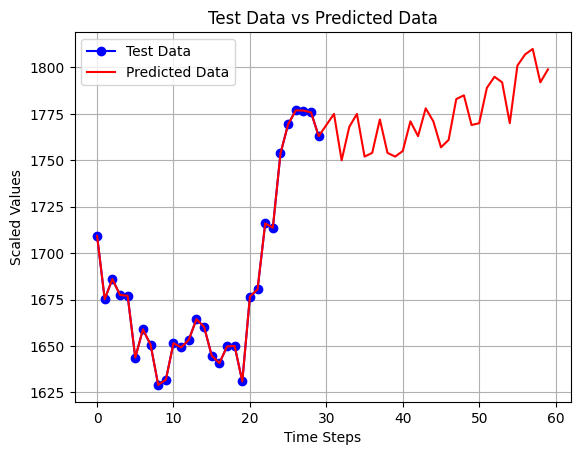

In [59]:
plt.plot(X_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([X_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()